# 전처리

**Import**

In [3]:
import os
import re
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer
from soupsieve import SelectorSyntaxError

**Google Drive 마운트 및 JSON 파일 로드**

In [4]:
# Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# JSON 파일 경로 설정
# JSON 파일이 여러개라서 JSON 파일들이 저장된 폴더 경로 설정
# json_folder_path = '/content/drive/MyDrive/파란학기 프로젝트'
json_file_path = '/content/drive/MyDrive/1차데이터/test_result(1~1061).json'

In [6]:
# JSON 파일 로드
import json
with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

**HTML에서 텍스트 추출 및 텍스트를 일정 길이로 나누기**

In [7]:
# HTML에서 텍스트 추출과 불필요한 공백 제거
def extract_text_from_html(html_code):
    if not isinstance(html_code, str):
        print("경고: HTML 코드가 문자열 형식이 아닙니다. 문자열로 변환합니다.")
        html_code = str(html_code)

    # 스크립트, 스타일, 주석 제거
    html_code = re.sub(r'<script.*?>.*?</script>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<style.*?>.*?</style>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<!--.*?-->', '', html_code, flags=re.DOTALL)

    # HTML 태그 제거 및 공백 정리
    text = re.sub('<[^<]+?>', '', html_code)  # HTML 태그 제거
    text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나의 공백으로 치환
    return text.strip()

In [8]:
# 텍스트를 일정 길이로 나누기
def split_text(text, max_length=512):
    words = text.split()
    chunks = []
    chunk = ""

    for word in words:
        if len(chunk) + len(word) + 1 <= max_length:
            chunk += (" " + word if chunk else word)
        else:
            chunks.append(chunk)
            chunk = word
    if chunk:
        chunks.append(chunk)

    return chunks

**CSS 문자열을 딕셔너리로 변환하는 함수 정의**

In [9]:
def css_to_dict(css_string):

    css_dict = {}

    # CSS 규칙 패턴: 선택자와 속성-값 쌍을 추출
    pattern = re.compile(r'([^{]+)\s*\{\s*([^}]+)\s*\}')
    matches = pattern.findall(css_string)

    for selector, properties in matches:
        selector = selector.strip()
        properties_dict = {}

        # 속성-값 쌍 추출
        for prop_value in properties.split(';'):
            if prop_value.strip():
                # 첫 번째 콜론만 기준으로 분리 (복합 값 처리)
                parts = prop_value.split(":", 1)
                if len(parts) == 2:
                    prop, value = parts
                    properties_dict[prop.strip()] = value.strip()

        css_dict[selector] = properties_dict

    return css_dict

특정 데이터의 변환 (문자열에서 딕셔너리로)결과 확인하기 <- 굳이 안돌려봐도 되긴함

In [ ]:
css_styles = data['1033']['CSS']  # 예시로 10번 데이터 확인, 필요에 따라 변경, 익덱스 번호가 아니라 데이터 번호를 기입해야함
css_dict = css_to_dict(css_styles) if isinstance(css_styles, str) else {}

print("변환된 CSS 딕셔너리:", css_dict)

 HTML에 CSS 스타일을 적용하는 함수

In [10]:
# CSS 적용 후 HTML 콘텐츠 반환
def apply_css_to_dom(html_content, css_styles):
    """
    HTML 콘텐츠에 CSS 스타일을 적용한 후 반환합니다.
    css_styles가 딕셔너리가 아닐 경우, 변환할 수 있는지 확인하고
    변환이 불가능하면 CSS 적용을 건너뜁니다.
    """
    soup = BeautifulSoup(html_content, 'html.parser')  # BeautifulSoup을 사용해 HTML을 DOM 구조로 변환

    css_styles = css_to_dict(css_styles)

    # CSS 스타일이 올바른 딕셔너리 형식일 경우 적용
    for selector, styles in css_styles.items():
        try:
            elements = soup.select(selector)  # CSS 선택자에 해당하는 HTML 요소를 찾아서 반환
        except SelectorSyntaxError:
            print(f"잘못된 선택자 무시됨: {selector}")
            continue  # 오류 발생 시 해당 선택자를 무시하고 다음으로 진행

        for element in elements:  # 각 HTML 요소에 대해 반복문을 실행하여 스타일을 적용
            if 'style' not in element.attrs:
                element.attrs['style'] = ""
            for prop, value in styles.items():
                element.attrs['style'] += f"{prop}: {value}; "

    return str(soup)

HTML과 CSS 매핑 잘됐는지 결과 확인하는 함수 정의 <- 굳이 안돌려봐도 되긴함

In [ ]:
# 특정 인덱스에서 CSS 적용 후 HTML 콘텐츠 반환
def apply_css_and_display_html(data, index):
    # 데이터에서 특정 인덱스의 HTML 콘텐츠와 CSS 스타일 가져오기
    item = data[str(index)]  # 'index'에 맞는 항목을 가져옴
    html_content = item['HTML']
    css_styles = item['CSS']

    # CSS 변환 및 HTML 적용
    result_html = apply_css_to_dom(html_content, css_styles)

    # 결과 HTML 출력
    print("CSS가 적용된 HTML 콘텐츠:")
    print(result_html)

특정 데이터의 매핑 결과 확인하기 <- 굳이 안돌려봐도 되긴함

In [ ]:
# 특정 인덱스(예: '10')의 결과 확인
apply_css_and_display_html(data, 10)

CSS가 적용된 HTML 콘텐츠:
<div class="gnb-menu-container" id="gnb-menu-container" style='overflow: visible;-webkit-border-horizontal-spacing: 0px; -webkit-border-image: none; -webkit-border-vertical-spacing: 0px; -webkit-box-align: stretch; -webkit-box-decoration-break: slice; -webkit-box-direction: normal; -webkit-box-flex: 0; -webkit-box-ordinal-group: 1; -webkit-box-orient: horizontal; -webkit-box-pack: start; -webkit-box-reflect: none; -webkit-font-smoothing: auto; -webkit-line-break: auto; -webkit-line-clamp: none; -webkit-locale: "ko-KR"; -webkit-mask-box-image: none; -webkit-mask-box-image-outset: 0; -webkit-mask-box-image-repeat: stretch; -webkit-mask-box-image-slice: 0 fill; -webkit-mask-box-image-source: none; -webkit-mask-box-image-width: auto; -webkit-print-color-adjust: economy; -webkit-rtl-ordering: logical; -webkit-tap-highlight-color: rgba(0, 0, 0, 0.18); -webkit-text-combine: none; -webkit-text-decorations-in-effect: none; -webkit-text-fill-color: rgb(0, 0, 0); -webkit-text-o

**중복 제거 함수**

In [11]:
# 중복 제거 함수 (개선된 버전)
def remove_duplicates_from_dataframe(df, subset=None, keep='first', sort_by=None):
    if sort_by:
        df = df.sort_values(by=sort_by).reset_index(drop=True)
    return df.drop_duplicates(subset=subset, keep=keep).reset_index(drop=True)

**추출한 텍스트 데이터 벡터화하는 함수**

HTML+CSS 현재 문서의 구조를 이해하거나 분석하는것이 중요하므로 벡터화 필요없음

In [12]:
def vectorize_text(data):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors = vectorizer.fit_transform(data)
    return vectors

**PCA 시각화 함수**

In [13]:
def plot_pca_3d(vectors, df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(vectors.toarray())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    color_map = {
        'X': 'blue',  # 다크패턴 없음
        'O': {
            '압박형': 'red',
            '방해형': 'green',
            '오도형': 'orange'
        }
    }

    colors = []
    for _, row in df.iterrows():
        if row['다크패턴 여부'] == 'X':
            colors.append(color_map['X'])
        else:
            colors.append(color_map['O'][row['type']])

    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, marker='o')

    ax.set_xlabel('primary keyword')
    ax.set_ylabel('display style')
    ax.set_zlabel('darkpattern type')
    plt.show()

**데이터 중복 제거 후 정의한 함수 호출해 전처리하는 함수**

In [13]:
# HTML 내용 처리 함수
def process_html_contents(unique_data):
    processed_texts = []
    labels = []
    types = []
    preprocessed_htmls = []

    for item in unique_data:
        html_content = item['HTML']
        css_styles = item['CSS']

        html_with_css = apply_css_to_dom(html_content, css_styles)
        extracted_text = extract_text_from_html(html_with_css)

        preprocessed_htmls.append(html_with_css)
        processed_texts.append(extracted_text)
        labels.append(item['다크패턴 여부'])
        types.append(item['type'] if item['다크패턴 여부'] == 'O' else '')

    df = pd.DataFrame({
        '다크패턴 여부': labels,
        'type': types,
        '추출한 텍스트': processed_texts,
        'HTML+CSS': preprocessed_htmls
    })

    return df

In [14]:
# JSON에서 중복 제거 및 데이터 전처리
unique_data = []
seen = set()

for item in data.values():
    html_content = item.get('HTML')
    if html_content not in seen:
        seen.add(html_content)
        unique_data.append(item)

In [ ]:
# 중복 제거된 데이터를 process_html_contents에 전달
df_no_duplicates = process_html_contents(unique_data)
print("최종 DataFrame:")
print(df_no_duplicates)

In [ ]:
# 텍스트 벡터화 및 시각화
vectors = vectorize_text(df_no_duplicates['추출한 텍스트'].tolist())

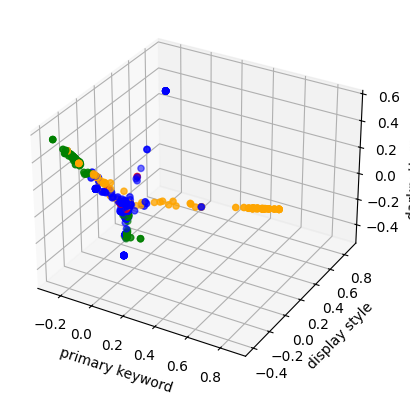

In [ ]:
# 2. 시각화 함수 호출 (차원 축소 및 시각화)
plot_pca_3d(vectors, df_no_duplicates)

In [ ]:
# 그냥 전처리한 데이터 확인용 (실행안해도 됨)
df_transposed = df_no_duplicates.T
df_transposed.T.iloc[10:21]

# BERT 기계학습

**기본적으로 다 1번씩 실행하기**

In [ ]:
!pip install datasets

In [17]:
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    # HTML과 CSS를 하나의 문자열로 합침
    df['HTML_CSS'] = df['HTML+CSS'].apply(lambda x: x if isinstance(x, str) else "")

    # 라벨 인코딩
    label_encoder = LabelEncoder()

    # '다크패턴 여부' 대신 'type' 컬럼을 다중 클래스 레이블로 변환
    df['label'] = label_encoder.fit_transform(df['type'])  # 'type' 컬럼을 라벨로 사용

    # '추출한 텍스트'와 'HTML+CSS'도 사용하도록
    df['HTML_text'] = df['추출한 텍스트']  # 텍스트를 'HTML_CSS'와 함께 사용할 수 있도록

    return df[['HTML_CSS', 'HTML_text', 'label']]

# 전처리된 데이터
df_processed = preprocess_data(df_no_duplicates)


In [ ]:
from transformers import BertTokenizer

# BERT의 기본 토크나이저를 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 토큰화 함수 정의 (HTML_CSS만 사용)
def tokenize_html_css(examples):
    return tokenizer(examples['HTML_CSS'], padding='max_length', truncation=True, max_length=256)

# 토큰화 함수 정의 (HTML_text만 사용)
def tokenize_html_text(examples):
    return tokenizer(examples['HTML_text'], padding='max_length', truncation=True, max_length=256)


In [20]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# 학습 데이터와 테스트 데이터 나누기
train_texts_html_css, test_texts_html_css, train_labels, test_labels, train_texts_html_text, test_texts_html_text = train_test_split(
    df_processed['HTML_CSS'].tolist(),
    df_processed['label'].tolist(),
    df_processed['HTML_text'].tolist(),  # HTML_text도 포함
    test_size=0.2, random_state=42, stratify=df_processed['label']  # 다중 클래스 분포가 동일하도록 stratify 설정
)

# 데이터셋 생성
train_data = Dataset.from_dict({
    'HTML_CSS': train_texts_html_css,
    'HTML_text': train_texts_html_text,
    'label': train_labels  # 다중 분류의 레이블
})

test_data = Dataset.from_dict({
    'HTML_CSS': test_texts_html_css,
    'HTML_text': test_texts_html_text,
    'label': test_labels  # 다중 분류의 레이블
})

# 데이터셋에 각각의 토큰화 적용 (병렬 처리 활성화)
train_data_html_css = train_data.map(tokenize_html_css, batched=True, num_proc=4)
test_data_html_css = test_data.map(tokenize_html_css, batched=True, num_proc=4)

train_data_html_text = train_data.map(tokenize_html_text, batched=True, num_proc=4)
test_data_html_text = test_data.map(tokenize_html_text, batched=True, num_proc=4)


Map (num_proc=4):   0%|          | 0/484 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/122 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/484 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/122 [00:00<?, ? examples/s]

**아래 코드는 토큰화한 데이터 합치기(html+css, 추출한 텍스트)**

In [57]:
from datasets import Dataset

# 토큰화된 데이터셋 결합 함수 정의
def combine_datasets(dataset1, dataset2):
    # 'input_ids'와 'attention_mask'를 합치기
    combined_input_ids = [d1 + d2 for d1, d2 in zip(dataset1['input_ids'], dataset2['input_ids'])]
    combined_attention_mask = [m1 + m2 for m1, m2 in zip(dataset1['attention_mask'], dataset2['attention_mask'])]

    # 레이블과 'type' 컬럼은 동일하게 유지
    combined_dataset = {
        'input_ids': combined_input_ids,
        'attention_mask': combined_attention_mask,
        'label': dataset1['label'],  # 다중 분류 레이블 그대로 사용
    }

    return Dataset.from_dict(combined_dataset)

# 결합된 학습 및 테스트 데이터 생성
combined_train_data = combine_datasets(train_data_html_css, train_data_html_text)
combined_test_data = combine_datasets(test_data_html_css, test_data_html_text)


In [ ]:
# 데이터 분할 후 확인
print(f"훈련 데이터 크기: {len(combined_train_data)}")
print(f"테스트 데이터 크기: {len(combined_test_data)}")

# # 각 클래스의 비율 확인
# print("훈련 데이터 클래스 분포:\n", pd.Series(train_types).value_counts(normalize=True))
# print("테스트 데이터 클래스 분포:\n", pd.Series(test_types).value_counts(normalize=True))


In [ ]:
df_processed.head()

**아래 코드는 학습시키는 함수**

**튜닝한 후, 이것만 계속 실행시키면 됨, 위 코드들 다시 할 필요 없음**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import Trainer, TrainingArguments, BertForSequenceClassification
import numpy as np

# type_encoded에 대한 라벨을 사람이 이해할 수 있는 이름으로 매핑
type_labels = {
    0: "다크패턴 아닌 데이터",
    1: "방해형",
    2: "압박형",
    3: "오도형"
}

# 다중 클래스 F1, 정확도 및 유형별 정확도를 계산하는 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # 예측 레이블 계산

    # 전체 정확도 및 F1 점수 계산
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')

    # Type별 정확도 계산
    type_accuracies = {}
    for i in range(4):  # 0~3까지 각 클래스에 대해
        type_mask = (labels == i)
        if np.any(type_mask):  # 해당 타입에 데이터가 있는 경우에만 계산
            type_acc = accuracy_score(labels[type_mask], predictions[type_mask])
            type_accuracies[f"{type_labels[i]}_accuracy"] = type_acc

    return {
        "accuracy": acc,
        "f1": f1,
        **type_accuracies  # Type별 정확도 추가
    }

# 모델 초기화 (4개의 클래스로 설정)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# 훈련 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    report_to='none'
)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_data,
    eval_dataset=combined_test_data,
    compute_metrics=compute_metrics
)

# 학습 시작
trainer.train()

# 모델 평가 및 결과 예측
eval_results = trainer.predict(combined_test_data)

# 예측값과 실제값
predictions = np.argmax(eval_results.predictions, axis=-1)
labels = eval_results.label_ids

# classification report 출력 (표 형식으로 직접 출력)
print("Classification Report:")
print(classification_report(labels, predictions, target_names=[type_labels[i] for i in range(4)]))

# compute_metrics 함수 직접 호출
metrics = compute_metrics((eval_results.predictions, eval_results.label_ids))

# 전체 정확도와 각 유형에 대한 정확도 출력
print(f"\n전체 정확도 (Accuracy): {metrics['accuracy']:.2f}")
print(f"F1 스코어 (F1 Score): {metrics['f1']:.2f}")
for label, accuracy in metrics.items():
    if "_accuracy" in label:
        print(f"{label}: {accuracy:.2f}")


# test 데이터에서 다크패턴인 데이터 수 확인용

In [ ]:
# 각 유형별 데이터 수 계산
type_counts = {}
for i in range(4):  # 0부터 3까지 각 클래스에 대해
    type_counts[f"{type_labels[i]}_count"] = np.sum(labels == i)

# 결과 출력
for label, count in type_counts.items():
    print(f"{label}: {count}개")


In [ ]:
# 다크패턴 아닌 데이터와 다크패턴 데이터 수 계산
non_darkpattern_count = np.sum(labels == 0)  # 레이블 0: 다크패턴 아닌 데이터
darkpattern_count = np.sum(labels != 0)     # 레이블 1, 2, 3: 다크패턴인 데이터

# 결과 출력
print(f"다크패턴 아닌 데이터 수: {non_darkpattern_count}")
print(f"다크패턴인 데이터 수: {darkpattern_count}")


In [ ]:
# 다크패턴을 올바르게 판별한 데이터 수 계산
correct_darkpattern_predictions = np.sum((predictions != 0) & (labels != 0))  # 다크패턴인 데이터가 올바르게 예측된 수
correct_non_darkpattern_predictions = np.sum((predictions == 0) & (labels == 0))  # 다크패턴 아닌 데이터가 올바르게 예측된 수

# 각 유형별 올바르게 판별한 데이터 수 계산
correct_type_accuracies = {}
for i in range(1, 4):  # 다크패턴 유형(1, 2, 3)에 대해
    correct_type_accuracies[f"{type_labels[i]}_correct"] = np.sum((predictions == i) & (labels == i))

# 결과 출력
print(f"다크패턴으로 올바르게 판별한 데이터 수: {correct_darkpattern_predictions}")
print(f"다크패턴 아닌 데이터로 올바르게 판별한 데이터 수: {correct_non_darkpattern_predictions}")

# 각 유형별 올바르게 판별한 데이터 수 출력
for i in range(1, 4):
    print(f"{type_labels[i]} - 올바르게 판별된 데이터 수: {correct_type_accuracies[f'{type_labels[i]}_correct']}")


# BERT 이진 분류

**기본적으로 다 1번씩 실행하기**

In [ ]:
def preprocess_data(df):
    # HTML과 CSS를 하나의 문자열로 합침
    df['HTML_CSS'] = df['HTML+CSS'].apply(lambda x: x if isinstance(x, str) else "")

    # 라벨 인코딩 (다크패턴인 데이터: 1, 아닌 데이터: 0으로 설정)
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['다크패턴 여부'])

    # 반대로 변환
    df['label'] = df['label'].apply(lambda x: 1 if x == 0 else 0)

    # 'type' 컬럼도 라벨 인코딩
    df['type_encoded'] = label_encoder.fit_transform(df['type'])

    # '추출한 텍스트'와 'HTML+CSS'도 사용하도록
    df['HTML_text'] = df['추출한 텍스트']  # 텍스트를 'HTML_CSS'와 함께 사용할 수 있도록
    return df[['HTML_CSS', 'HTML_text', 'label', 'type_encoded']]

# 전처리된 데이터
df_processed = preprocess_data(df_no_duplicates)



In [ ]:
from transformers import BertTokenizer

# BERT의 기본 토크나이저를 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 토큰화 함수 정의 (HTML_CSS만 사용)
def tokenize_html_css(examples):
    return tokenizer(examples['HTML_CSS'], padding='max_length', truncation=True, max_length=256)

# 토큰화 함수 정의 (HTML_text만 사용)
def tokenize_html_text(examples):
    return tokenizer(examples['HTML_text'], padding='max_length', truncation=True, max_length=256)


**아래 코드(토큰화하는 코드)가 진짜 오래 걸림, 40분~1시간정도?**

In [ ]:
from sklearn.model_selection import train_test_split


# 학습 데이터와 테스트 데이터 나누기
train_texts_html_css, test_texts_html_css, train_labels, test_labels, train_type_encodeds, test_type_encodeds, train_texts_html_text, test_texts_html_text = train_test_split(
    df_processed['HTML_CSS'].tolist(),
    df_processed['label'].tolist(),
    df_processed['type_encoded'].tolist(),
    df_processed['HTML_text'].tolist(),  # HTML_text도 포함
    test_size=0.2, random_state=42, stratify=df_processed['type_encoded']
)

# 데이터셋 생성
train_data = Dataset.from_dict({
    'HTML_CSS': train_texts_html_css,
    'HTML_text': train_texts_html_text,
    'label': train_labels,
    'type': train_type_encodeds
})

test_data = Dataset.from_dict({
    'HTML_CSS': test_texts_html_css,
    'HTML_text': test_texts_html_text,
    'label': test_labels,
    'type': test_type_encodeds
})

# 데이터셋에 각각의 토큰화 적용 (병렬 처리 활성화)
train_data_html_css = train_data.map(tokenize_html_css, batched=True, num_proc=4)
test_data_html_css = test_data.map(tokenize_html_css, batched=True, num_proc=4)

train_data_html_text = train_data.map(tokenize_html_text, batched=True, num_proc=4)
test_data_html_text = test_data.map(tokenize_html_text, batched=True, num_proc=4)

**아래 코드는 토큰화한 데이터 합치기(html+css, 추출한 텍스트)**

In [ ]:
from datasets import Dataset, concatenate_datasets

# 토큰화된 데이터셋 결합 함수 정의
def combine_datasets(dataset1, dataset2):
    combined_dataset = {
        'input_ids': [d1 + d2 for d1, d2 in zip(dataset1['input_ids'], dataset2['input_ids'])],
        'attention_mask': [m1 + m2 for m1, m2 in zip(dataset1['attention_mask'], dataset2['attention_mask'])],
        'label': dataset1['label'],  # 동일한 레이블 사용
        'type': dataset1['type']  # 'type'도 함께 결합
    }
    return Dataset.from_dict(combined_dataset)

# 결합된 학습 및 테스트 데이터 생성
combined_train_data = combine_datasets(train_data_html_css, train_data_html_text)
combined_test_data = combine_datasets(test_data_html_css, test_data_html_text)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, BertForSequenceClassification

# 평가 지표 계산 함수 정의
def compute_metrics(eval_pred):
    # 모델의 예측값(predictions)과 실제 레이블(labels)을 가져옴
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # 최종 예측 레이블로 변환

    # 정확도(Accuracy) 계산
    acc = accuracy_score(labels, predictions)
    # F1 스코어 계산 (binary로 설정하여 이진 분류에 맞춤)
    f1 = f1_score(labels, predictions, average='binary')
    # ROC-AUC 계산 (positive label을 1로 지정)
    roc_auc = roc_auc_score(labels, logits[:, 1])

    return {"accuracy": acc, "f1": f1, "roc_auc": roc_auc}
# # 특정 레이어 동결 설정 함수 정의
# def freeze_layers(model, num_freeze_layers):
#     """
#     모델의 하위 num_freeze_layers 만큼의 레이어를 동결하여 학습하지 않도록 설정합니다.
#     """
#     # BERT 인코더의 하위 num_freeze_layers 레이어를 동결
#     for layer in model.bert.encoder.layer[:num_freeze_layers]:
#         for param in layer.parameters():
#             param.requires_grad = False
#     print(f"동결된 레이어 수: {num_freeze_layers}")

# 모델 초기화 및 동결 레이어 설정
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# # 튜닝할 하위 레이어 수 설정 (예: 하위 6개 레이어 동결)
# num_freeze_layers = 4
# freeze_layers(model, num_freeze_layers)

# 훈련 설정, 하이퍼파라미터 튜닝 옵션
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    report_to='none'
)


# Trainer 초기화 (compute_metrics 추가하여 평가 지표 계산)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_data,
    eval_dataset=combined_test_data,
    compute_metrics=compute_metrics  # 평가 지표 계산 함수 추가
)

# 학습 시작
trainer.train()

# 모델 평가 후 시각화
# 평가 결과 얻기
eval_results = trainer.predict(combined_test_data)

# 실제 레이블(labels)과 예측 확률(probs) 추출
probs = eval_results.predictions[:, 1]
labels = eval_results.label_ids

# ROC 곡선과 AUC 계산
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 정확도, F1 점수, AUC 출력
print(f"정확도 (Accuracy): {eval_results.metrics['test_accuracy']:.2f}")
print(f"F1 점수 (F1 Score): {eval_results.metrics['test_f1']:.2f}")
print(f"ROC-AUC (AUC Score): {eval_results.metrics['test_roc_auc']:.2f}")


# 이 아래는 아님, 무시하기

In [ ]:
import os
import re
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer
from soupsieve import SelectorSyntaxError

# HTML에서 텍스트 추출과 불필요한 공백 제거
def extract_text_from_html(html_code):
    if not isinstance(html_code, str):
        print("경고: HTML 코드가 문자열 형식이 아닙니다. 문자열로 변환합니다.")
        html_code = str(html_code)

    # 스크립트, 스타일, 주석 제거
    html_code = re.sub(r'<script.*?>.*?</script>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<style.*?>.*?</style>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<!--.*?-->', '', html_code, flags=re.DOTALL)

    # HTML 태그 제거 및 공백 정리
    text = re.sub('<[^<]+?>', '', html_code)  # HTML 태그 제거
    text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나의 공백으로 치환
    return text.strip()

# 텍스트를 일정 길이로 나누기
def split_text(text, max_length=512):
    words = text.split()
    chunks = []
    chunk = ""

    for word in words:
        if len(chunk) + len(word) + 1 <= max_length:
            chunk += (" " + word if chunk else word)
        else:
            chunks.append(chunk)
            chunk = word
    if chunk:
        chunks.append(chunk)

    return chunks

def css_to_dict(css_string):
    css_dict = {}

    # CSS 규칙 패턴: 선택자와 속성-값 쌍을 추출
    pattern = re.compile(r'([^{]+)\s*\{\s*([^}]+)\s*\}')
    matches = pattern.findall(css_string)

    for selector, properties in matches:
        selector = selector.strip()
        properties_dict = {}

        # 속성-값 쌍 추출
        for prop_value in properties.split(';'):
            if prop_value.strip():
                # 첫 번째 콜론만 기준으로 분리 (복합 값 처리)
                parts = prop_value.split(":", 1)
                if len(parts) == 2:
                    prop, value = parts
                    properties_dict[prop.strip()] = value.strip()

        css_dict[selector] = properties_dict

    return css_dict

# CSS 적용 후 HTML 콘텐츠 반환
def apply_css_to_dom(html_content, css_styles):
    """
    HTML 콘텐츠에 CSS 스타일을 적용한 후 반환합니다.
    css_styles가 딕셔너리가 아닐 경우, 변환할 수 있는지 확인하고
    변환이 불가능하면 CSS 적용을 건너뜁니다.
    """
    soup = BeautifulSoup(html_content, 'html.parser')  # BeautifulSoup을 사용해 HTML을 DOM 구조로 변환

    css_styles = css_to_dict(css_styles)

    # CSS 스타일이 올바른 딕셔너리 형식일 경우 적용
    for selector, styles in css_styles.items():
        try:
            elements = soup.select(selector)  # CSS 선택자에 해당하는 HTML 요소를 찾아서 반환
        except SelectorSyntaxError:
            print(f"잘못된 선택자 무시됨: {selector}")
            continue  # 오류 발생 시 해당 선택자를 무시하고 다음으로 진행

        for element in elements:  # 각 HTML 요소에 대해 반복문을 실행하여 스타일을 적용
            if 'style' not in element.attrs:
                element.attrs['style'] = ""
            for prop, value in styles.items():
                element.attrs['style'] += f"{prop}: {value}; "

    return str(soup)

# 중복 제거 함수 (개선된 버전)
def remove_duplicates_from_dataframe(df, subset=None, keep='first', sort_by=None):
    if sort_by:
        df = df.sort_values(by=sort_by).reset_index(drop=True)
    return df.drop_duplicates(subset=subset, keep=keep).reset_index(drop=True)

def vectorize_text(data):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors = vectorizer.fit_transform(data)
    return vectors

def plot_pca_3d(vectors, df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(vectors.toarray())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    color_map = {
        'X': 'blue',  # 다크패턴 없음
        'O': {
            '압박형': 'red',
            '방해형': 'green',
            '오도형': 'orange'
        }
    }

    colors = []
    for _, row in df.iterrows():
        if row['다크패턴 여부'] == 'X':
            colors.append(color_map['X'])
        else:
            colors.append(color_map['O'][row['type']])

    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, marker='o')

    ax.set_xlabel('primary keyword')
    ax.set_ylabel('display style')
    ax.set_zlabel('darkpattern type')
    plt.show()

# HTML DOM 트리 구조 만들기
def create_html_dom_structure(html_content):
    """
    HTML 문자열을 BeautifulSoup을 사용하여 DOM 트리 구조로 변환합니다.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

# HTML과 CSS를 따로 반환하는 함수
def extract_html_and_css(html_content, css_styles):
    """
    HTML 콘텐츠와 CSS 스타일을 각각 별도로 반환합니다.
    HTML은 DOM 트리 구조로, CSS는 딕셔너리 구조로 반환됩니다.
    """
    # HTML DOM 트리 구조 생성
    dom_structure = create_html_dom_structure(html_content)

    # CSS 딕셔너리 구조 생성
    css_dict = css_to_dict(css_styles)

    return dom_structure, css_dict

# HTML 내용 처리 함수
def process_html_contents(unique_data):
    processed_texts = []
    labels = []
    types = []
    preprocessed_htmls = []
    dom_structures = []
    css_dicts = []

    for item in unique_data:
        html_content = item['HTML']
        css_styles = item['CSS']

        # HTML과 CSS를 각각 따로 처리
        dom_structure, css_dict = extract_html_and_css(html_content, css_styles)

        # CSS를 HTML에 적용
        html_with_css = apply_css_to_dom(html_content, css_styles)
        extracted_text = extract_text_from_html(html_with_css)

        preprocessed_htmls.append(html_with_css)
        processed_texts.append(extracted_text)
        labels.append(item['다크패턴 여부'])
        types.append(item['type'] if item['다크패턴 여부'] == 'O' else '')
        dom_structures.append(str(dom_structure))
        css_dicts.append(css_dict)

    df = pd.DataFrame({
        '다크패턴 여부': labels,
        'type': types,
        '추출한 텍스트': processed_texts,
        'HTML+CSS': preprocessed_htmls,
        'HTML_DOM': dom_structures,
        'CSS_dict': css_dicts
    })

    return df

# JSON에서 중복 제거 및 데이터 전처리
unique_data = []
seen = set()

for item in data.values():
    html_content = item.get('HTML')
    if html_content not in seen:
        seen.add(html_content)
        unique_data.append(item)

# 중복 제거된 데이터를 process_html_contents에 전달
df_no_duplicates = process_html_contents(unique_data)

# 결과 출력
print("최종 DataFrame:")
print(df_no_duplicates)

# # 텍스트 벡터화 및 시각화
# vectors = vectorize_text(df_no_duplicates['추출한 텍스트'].tolist())

# 2. 시각화 함수 호출 (차원 축소 및 시각화)
plot_pca_3d(vectors, df_no_duplicates)


In [ ]:
import networkx as nx
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import pandas as pd

def build_html_graph(df_no_duplicates):
    graphs = []  # 각 HTML 페이지마다 하나의 그래프를 생성

    # 라벨 인코딩 (다크패턴 여부와 타입)
    label_encoder = LabelEncoder()
    df_no_duplicates['다크패턴 여부'] = label_encoder.fit_transform(df_no_duplicates['다크패턴 여부'])
    df_no_duplicates['type'] = label_encoder.fit_transform(df_no_duplicates['type'].fillna(''))  # NaN을 빈 문자열로 대체하여 인코딩

    for _, row in df_no_duplicates.iterrows():
        G = nx.DiGraph()  # 방향성 그래프 생성
        html_content = row['HTML_DOM']

        # HTML을 BeautifulSoup으로 파싱
        soup = BeautifulSoup(html_content, 'html.parser')

        # 노드 ID를 숫자 인덱스로 관리
        node_id_map = {}  # 노드의 ID를 정수 인덱스로 매핑
        node_features = []

        # 노드 생성
        for idx, element in enumerate(soup.find_all(True)):
            node_id_map[element] = idx  # 각 element를 고유한 정수 ID에 매핑
            tag = element.name  # 태그명
            text_content = element.get_text(strip=True)  # 텍스트 콘텐츠
            G.add_node(idx, tag=tag, text=text_content)  # 그래프에 노드 추가

            # 특징 벡터 생성
            node_features.append(text_content)

            # 부모-자식 관계 엣지 추가
            for child in element.find_all(True):
                if child in node_id_map:
                    G.add_edge(idx, node_id_map[child])  # 정수 인덱스로 엣지 추가

        # 노드 특징을 PyTorch 텐서로 변환
        x = torch.tensor([len(text) for text in node_features], dtype=torch.float).view(-1, 1)  # 텍스트 길이 특징 예시

        # 그래프의 엣지를 PyTorch Geometric 형식으로 변환
        edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.number_of_edges() > 0 else torch.empty((2, 0), dtype=torch.long)

        # 레이블 (다크패턴 여부, type) 설정
        y = torch.tensor([row['다크패턴 여부'], row['type']], dtype=torch.long)

        # 그래프 데이터 객체 생성 (PyTorch Geometric)
        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph_data)

    return graphs

# GNN 학습에 사용할 그래프 리스트 생성
graphs = build_html_graph(df_no_duplicates)


In [ ]:
import networkx as nx
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import pandas as pd

def build_html_graph(df_no_duplicates, vectors):
    graphs = []  # 각 HTML 페이지마다 하나의 그래프를 생성

    # 라벨 인코딩 (다크패턴 여부와 타입)
    label_encoder = LabelEncoder()
    df_no_duplicates['다크패턴 여부'] = label_encoder.fit_transform(df_no_duplicates['다크패턴 여부'])
    df_no_duplicates['type'] = label_encoder.fit_transform(df_no_duplicates['type'].fillna(''))  # NaN을 빈 문자열로 대체하여 인코딩

    for idx, row in df_no_duplicates.iterrows():
        G = nx.DiGraph()  # 방향성 그래프 생성
        html_content = row['HTML_DOM']

        # HTML을 BeautifulSoup으로 파싱
        soup = BeautifulSoup(html_content, 'html.parser')

        # 노드 ID를 숫자 인덱스로 관리
        node_id_map = {}  # 노드의 ID를 정수 인덱스로 매핑
        node_features = []

        # HTML 노드에 대한 텍스트 벡터화된 특징을 가져옵니다.
        page_vector = vectors[idx].toarray().flatten()  # 벡터화된 텍스트 (전체 HTML 페이지에 대해 벡터화된 결과)

        # 노드 생성 및 벡터 할당
        for element_idx, element in enumerate(soup.find_all(True)):
            node_id_map[element] = element_idx  # 각 element를 고유한 정수 ID에 매핑
            tag = element.name  # 태그명
            text_content = element.get_text(strip=True)  # 텍스트 콘텐츠
            G.add_node(element_idx, tag=tag, text=text_content)  # 그래프에 노드 추가

            # 텍스트 콘텐츠를 벡터화된 형태로 저장 (일반적으로 벡터화된 텍스트를 노드 특성으로 사용)
            node_features.append(page_vector)  # 각 노드에 대해 전체 페이지 벡터 사용 (개별 노드에 맞는 벡터로 수정 가능)

            # 부모-자식 관계 엣지 추가
            for child in element.find_all(True):
                if child in node_id_map:
                    G.add_edge(element_idx, node_id_map[child])  # 정수 인덱스로 엣지 추가

        # 노드 특징을 PyTorch 텐서로 변환
        x = torch.tensor(node_features, dtype=torch.float)  # 벡터화된 텍스트 특징

        # 그래프의 엣지를 PyTorch Geometric 형식으로 변환
        edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.number_of_edges() > 0 else torch.empty((2, 0), dtype=torch.long)

        # 레이블 (다크패턴 여부, type) 설정
        y = torch.tensor([row['다크패턴 여부'], row['type']], dtype=torch.long)

        # 그래프 데이터 객체 생성 (PyTorch Geometric)
        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph_data)

    return graphs

graphs = build_html_graph(df_no_duplicates, vectors)

In [ ]:
# 그래프의 첫 번째 요소를 출력하여 확인
print(f"Number of graphs: {len(graphs)}")
for i, graph in enumerate(graphs[:3]):  # 첫 3개의 그래프에 대한 정보 출력
    print(f"\nGraph {i+1}:")
    print(f"Number of nodes: {graph.x.shape[0]}")  # 노드 수
    print(f"Number of edges: {graph.edge_index.shape[1]}")  # 엣지 수
    print(f"Node feature shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")
    print(f"Labels: {graph.y}")


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 모델 학습 함수
def train(model, loader, optimizer, criterion, device):
    model.train()
    for data in loader:  # 배치별로 데이터 처리
        data = data.to(device)
        optimizer.zero_grad()  # 그래디언트 초기화

        # GNN 모델을 통해 예측값 얻기
        out = model(data.x, data.edge_index)

        # 예측값에 대해 손실 계산
        loss = criterion(out, data.y)
        loss.backward()  # 그래디언트 계산
        optimizer.step()  # 옵티마이저 업데이트

        print(f"Loss: {loss.item()}")

# 모델 평가 함수
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)  # 예측 클래스
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")

# 데이터 준비
# 이미 build_html_graph 함수로 'graphs'를 생성했다고 가정합니다.

# DataLoader 준비
loader = DataLoader(graphs, batch_size=1, shuffle=True)

# 모델, 옵티마이저, 손실 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=1000, hidden_channels=64, out_channels=2).to(device)  # in_channels는 TF-IDF의 벡터 크기
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# 모델 학습
num_epochs = 10  # 에폭 수 설정
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # 데이터에 대해 레이블을 각 노드에 맞는 값으로 설정
    for data in loader:
        # 각 그래프의 노드에 대한 레이블 설정
        data.y = torch.tensor([data.y[0]] * data.x.size(0), dtype=torch.long)  # 각 노드에 대해 동일한 레이블을 사용

    train(model, loader, optimizer, criterion, device)
    evaluate(model, loader, device)  # 학습 후 평가


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# # 'type'을 원-핫 인코딩
# encoder_type = OneHotEncoder()
# type_encoded = encoder_type.fit_transform(df_no_duplicates[['type']])

# 특징 벡터 추출: 'HTML+CSS' 속성값과 문구 벡터
X = hstack([vectors,html_css_features])

# 레이블 설정
y = df_no_duplicates['다크패턴 여부']

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 모델을 학습하여 피처 중요도 추출
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 피처 중요도를 확인하고 중요한 속성만 선택
importances = rf_model.feature_importances_

# 상위 N개 중요한 피처를 선택
n_top_features = 10  # 상위 10개 피처를 선택
top_features_idx = np.argsort(importances)[-n_top_features:]
print(top_features_idx)

# 중요한 피처만 뽑아서 X_train과 X_test를 업데이트
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

# 모델 학습 및 평가 함수
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Classification Report:\n{report}\n")
    return model

# 1. Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
train_and_evaluate(log_reg_model, X_train_selected, X_test_selected, y_train, y_test, "Logistic Regression")

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate(rf_model, X_train_selected, X_test_selected, y_train, y_test, "Random Forest")

# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', random_state=42)
train_and_evaluate(svm_model, X_train_selected, X_test_selected, y_train, y_test, "Support Vector Machine")

# 4. Gradient Boosting Machine (GBM)
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
train_and_evaluate(gbm_model, X_train_selected, X_test_selected, y_train, y_test, "Gradient Boosting Machine")


[758 731 511 260 789 893 902 623  68 963]
Logistic Regression Accuracy: 0.88
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           O       1.00      0.72      0.84        54
           X       0.82      1.00      0.90        68

    accuracy                           0.88       122
   macro avg       0.91      0.86      0.87       122
weighted avg       0.90      0.88      0.87       122


Random Forest Accuracy: 0.90
Random Forest Classification Report:
              precision    recall  f1-score   support

           O       1.00      0.78      0.88        54
           X       0.85      1.00      0.92        68

    accuracy                           0.90       122
   macro avg       0.93      0.89      0.90       122
weighted avg       0.92      0.90      0.90       122


Support Vector Machine Accuracy: 0.90
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           O       

GradientBoostingClassifier(random_state=42)